In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from textblob import TextBlob
from sklearn.preprocessing import MinMaxScaler
import matplotlib.dates as mdates
from scipy.stats import linregress
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment import SentimentIntensityAnalyzer

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\hailea\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [2]:
pd.options.mode.chained_assignment = None

In [3]:
trump = pd.read_csv('trump_legacy/Trumps Legcy.csv')
stock = pd.read_csv('sp500_daily/sp500_stocks.csv')

In [4]:
trump['date'] = pd.to_datetime(trump['date'])
trump = trump.sort_values('date')

In [5]:
stock['Date'] = pd.to_datetime(stock['Date'])
stock = stock.sort_values('Date')

In [6]:
def is_only_link(text):
    text = text.strip()
    return text.startswith('http://') or text.startswith('https://') and ' ' not in text

# Remove rows where text is only a link
link_filtered = trump[~trump['text'].apply(is_only_link)]

In [7]:
# Remove rows where text is a retweet
retweet_filtered = link_filtered[~link_filtered['text'].str.startswith('RT')]

In [8]:
# Remove all links entirely
def remove_links(text):
    return ' '.join([word for word in text.split() if not is_only_link(word)])

trump['text'] = retweet_filtered['text'].apply(remove_links)
trump.dropna(subset=['text'], inplace=True)

In [9]:
sia = SentimentIntensityAnalyzer()

def get_polarity(text):
    return sia.polarity_scores(text)['compound']

vectorized_get_polarity = np.vectorize(get_polarity)

trump['polarity'] = vectorized_get_polarity(trump['text'])

In [10]:
trump['polarityCumulative'] = trump['polarity'].cumsum()

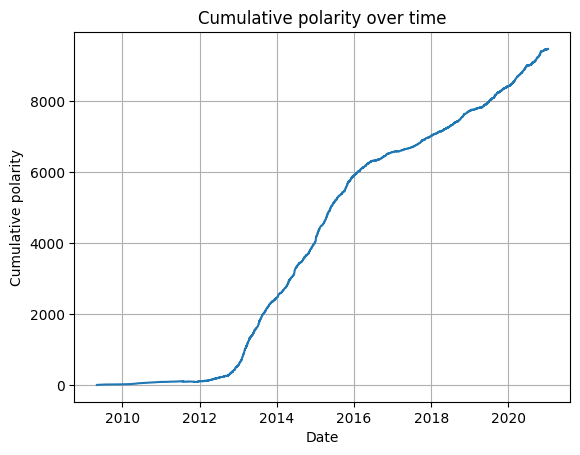

In [11]:
# Validating result is of similar trend to the EDA result
fig, ax = plt.subplots()
ax.plot(trump['date'], trump['polarityCumulative'])
ax.set(xlabel='Date', ylabel='Cumulative polarity',
       title='Cumulative polarity over time')
ax.grid()
plt.show()

In [12]:
def flatten_trend(x, y):
    x = mdates.date2num(x)
    slope, intercept, _, _, _ = linregress(x, y)
    trend_line = (slope * x) + intercept
    deviation = y - trend_line
    flat_average = np.mean(y)
    transformed_value = flat_average + deviation

    slope, intercept, _, _, _ = linregress(x, transformed_value)
    const_trend_line = (slope * x) + intercept
    # Subtract the constant trend line to get the final trend
    transformed_value -= const_trend_line
    slope, intercept, _, _, _ = linregress(x, transformed_value)
    const_trend_line = (slope * x) + intercept
    
    return trend_line, transformed_value, const_trend_line

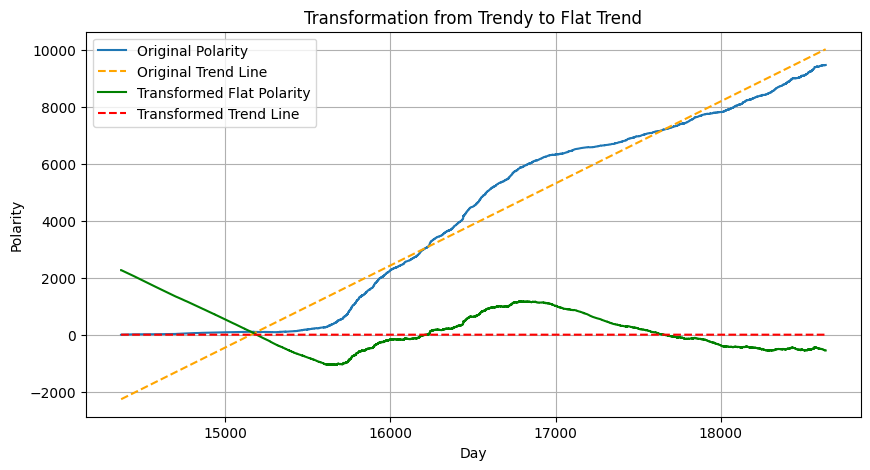

In [13]:
x = mdates.date2num(trump['date'])
trend_line, transformed_polarity, const_trend_line = flatten_trend(trump['date'], trump['polarityCumulative'])

plt.figure(figsize=(10, 5))
plt.plot(x, trump['polarityCumulative'], label='Original Polarity')
plt.plot(x, trend_line, label='Original Trend Line', linestyle='--', color='orange')
plt.plot(x, transformed_polarity, label='Transformed Flat Polarity', color='green')
plt.plot(x, const_trend_line, label='Transformed Trend Line', linestyle='--', color='red')
plt.title('Transformation from Trendy to Flat Trend')

plt.xlabel('Day')
plt.ylabel('Polarity')
plt.legend()
plt.grid(True)
plt.show()

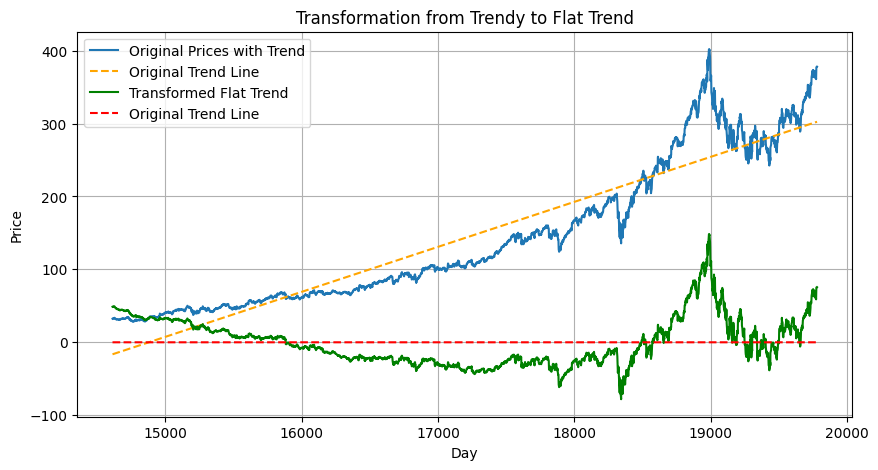

In [14]:
company_stock = stock[stock['Symbol'] == "ACN"]
x = mdates.date2num(company_stock['Date'])

trend_line, transformed_polarity, const_trend_line = flatten_trend(company_stock['Date'], company_stock['Adj Close'])

plt.figure(figsize=(10, 5))
plt.plot(x, company_stock['Adj Close'], label='Original Prices with Trend')
plt.plot(x, trend_line, label='Original Trend Line', linestyle='--', color='orange')
plt.plot(x, transformed_polarity, label='Transformed Flat Trend', color='green')
plt.plot(x, const_trend_line, label='Original Trend Line', linestyle='--', color='red')
plt.title('Transformation from Trendy to Flat Trend')

plt.xlabel('Day')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

In [15]:
method = "pearson"
stock_type = "Adj Close"
company = "ACN"

trump_2 = trump.copy()

company_stock = stock[stock['Symbol'] == company]
company_stock = company_stock[company_stock['Date'].between(trump['date'].min(), trump['date'].max())]

stock_min = company_stock[company_stock['Symbol'] == company][stock_type].min()
stock_max = company_stock[company_stock['Symbol'] == company][stock_type].max()

scaler = MinMaxScaler(feature_range=(stock_min, stock_max))
trump_2['polarityScaled'] = scaler.fit_transform(trump_2['polarityCumulative'].values.reshape(-1, 1))
trump_2['polarityScaled'] = pd.to_numeric(trump_2['polarityScaled'])

company_trump = trump_2[trump_2['date'].between(company_stock['Date'].min(), company_stock['Date'].max())]

trump_dates = company_trump['date']
stock_values = company_stock[['Date', stock_type]]
missing_dates = trump_dates[~trump_dates.isin(stock_values['Date'])]
stock_values = pd.concat([stock_values, pd.DataFrame({'Date': missing_dates, stock_type: np.nan})], ignore_index=True)
stock_values = stock_values.sort_values('Date')
stock_values = stock_values.reset_index(drop=True)
stock_values[stock_type] = stock_values[stock_type].interpolate()
stock_values = stock_values[stock_values['Date'].isin(trump_dates)]

_, transformed_polarity, _ = flatten_trend(company_trump['date'], company_trump['polarityScaled'])
company_trump["transformedPolarityScaled"] = transformed_polarity
_, transformed_adj_close, _ = flatten_trend(stock_values['Date'], stock_values[stock_type])
company_stock["transformedAdjClose"] = transformed_adj_close

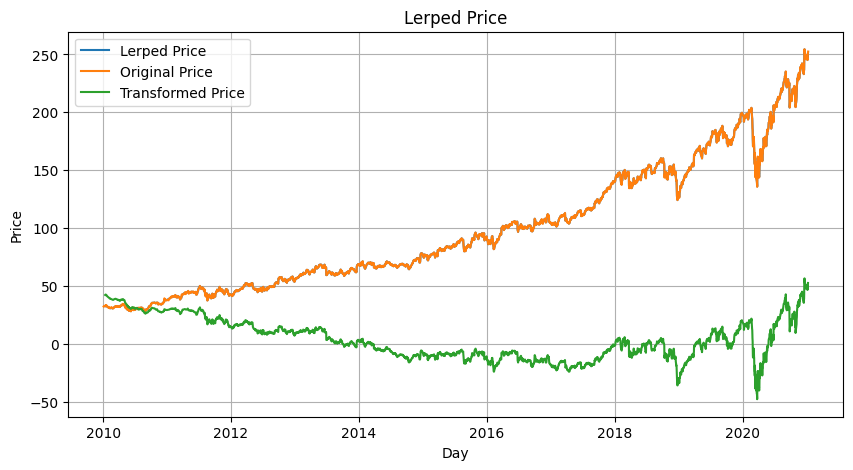

In [16]:
# Plot lerped price
plt.figure(figsize=(10, 5))
plt.plot(company_trump['date'], stock_values["Adj Close"], label='Lerped Price')
plt.plot(company_stock['Date'], company_stock["Adj Close"], label='Original Price')
plt.plot(stock_values['Date'], transformed_adj_close, label="Transformed Price")
plt.title('Lerped Price')
plt.xlabel('Day')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

In [17]:
def compute_correlation(company, stock_type, method):
    trump_2 = trump.copy()

    company_stock = stock[stock['Symbol'] == company]
    company_stock = company_stock[company_stock['Date'].between(trump['date'].min(), trump['date'].max())]

    stock_min = company_stock[company_stock['Symbol'] == company][stock_type].min()
    stock_max = company_stock[company_stock['Symbol'] == company][stock_type].max()

    scaler = MinMaxScaler(feature_range=(stock_min, stock_max))
    trump_2['polarityScaled'] = scaler.fit_transform(trump_2['polarityCumulative'].values.reshape(-1, 1))
    trump_2['polarityScaled'] = pd.to_numeric(trump_2['polarityScaled'])

    company_trump = trump_2[trump_2['date'].between(company_stock['Date'].min(), company_stock['Date'].max())]

    trump_dates = company_trump['date']
    stock_values = company_stock[['Date', stock_type]]
    missing_dates = trump_dates[~trump_dates.isin(stock_values['Date'])]
    stock_values = pd.concat([stock_values, pd.DataFrame({'Date': missing_dates, stock_type: np.nan})], ignore_index=True)
    stock_values = stock_values.sort_values('Date')
    stock_values = stock_values.reset_index(drop=True)
    stock_values[stock_type] = stock_values[stock_type].interpolate()
    stock_values = stock_values[stock_values['Date'].isin(trump_dates)]

    stock_values.dropna(inplace=True)
    company_trump = company_trump[company_trump['date'].between(stock_values['Date'].min(), stock_values['Date'].max())]
    transformed_polarity = company_trump['polarityScaled']
    transformed_adj_close = stock_values[stock_type]

    if len(transformed_polarity) == 0 or len(transformed_adj_close) == 0:
        return 0, 0

    std_correlation = abs(transformed_polarity.corr(transformed_adj_close, method=method))

    _, transformed_polarity, _ = flatten_trend(company_trump['date'], company_trump['polarityScaled'])
    company_trump["transformedPolarityScaled"] = transformed_polarity
    _, transformed_adj_close, _ = flatten_trend(stock_values['Date'], stock_values[stock_type])
    company_stock["transformedAdjClose"] = transformed_adj_close

    trans_correlation = abs(transformed_polarity.corr(transformed_adj_close, method=method))

    return std_correlation, trans_correlation

In [21]:
method = "spearman"
stock_type = "Adj Close"
correlations = {}
transformed_correlations = {}
companies = stock['Symbol'].unique()
top_stock = {}
top_trans_stock = {}

for company in companies:
    correlation, transformed_correlation = compute_correlation(company, stock_type, method)
    
    correlations[company] = correlation
    transformed_correlations[company] = transformed_correlation
    if top_stock == {} or correlation > list(top_stock.values())[0]:
        top_stock = {company: correlation}
    if top_trans_stock == {} or correlation > list(top_trans_stock.values())[0]:
        top_trans_stock = {company: transformed_correlation}

In [22]:
correlations = pd.Series(correlations)
correlations = correlations.sort_values(ascending=False)
correlations.head(10)

DAY     0.899337
CTLT    0.854065
MRNA    0.850592
PAYC    0.847112
PYPL    0.825948
ETSY    0.796042
VTRS    0.791549
ALLE    0.773402
MCK     0.743165
HLT     0.735805
dtype: float64

In [23]:
transformed_correlations = pd.Series(transformed_correlations)
transformed_correlations = transformed_correlations.sort_values(ascending=False)
transformed_correlations.head(10)

FOXA    0.833333
CTVA    0.809524
FOX     0.809524
HPE     0.793964
UBER    0.738095
IR      0.721117
DOW     0.690476
TSLA    0.674178
MRNA    0.654685
PYPL    0.632449
dtype: float64

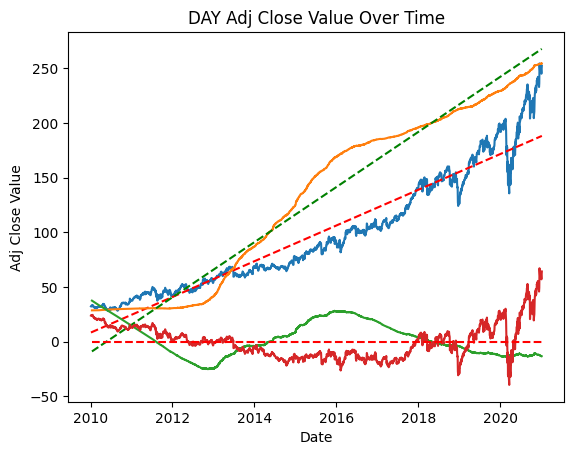

Correlation: 0.8993372390866515 | Transformed: 0.11873258529519437


In [24]:
symbol = list(top_stock.keys())[0]

plt.plot(company_stock['Date'], company_stock[stock_type])
z = np.polyfit(mdates.date2num(company_stock['Date']), company_stock[stock_type], 1)
p = np.poly1d(z)
plt.plot(company_stock['Date'], p(mdates.date2num(company_stock['Date'])), "r--", label='Trend Line (Stock)')

plt.plot(company_trump['date'], company_trump['polarityScaled'])
z_polarity = np.polyfit(mdates.date2num(company_trump['date']), company_trump['polarityScaled'], 1)
p_polarity = np.poly1d(z_polarity)
plt.plot(company_trump['date'], p_polarity(mdates.date2num(company_trump['date'])), "g--", label='Trend Line (Polarity)')

# Plot the flattened trend
_, transformed_polarity, _ = flatten_trend(company_trump['date'], company_trump['polarityScaled'])
company_trump["transformedPolarityScaled"] = transformed_polarity
_, transformed_adj_close, _ = flatten_trend(company_stock['Date'], company_stock[stock_type])
company_stock["transformedAdjClose"] = transformed_adj_close

plt.plot(company_trump['date'], transformed_polarity)
plt.plot(company_stock['Date'], transformed_adj_close)
plt.hlines(y=0, xmin=stock_values["Date"].min(), xmax=stock_values["Date"].max(), color='r', linestyle='--')

plt.xlabel('Date')
plt.ylabel(stock_type + ' Value')
plt.title(symbol + ' ' + stock_type + ' Value Over Time')
plt.show()

std, trans = compute_correlation(symbol, stock_type, method)

print("Correlation: " + str(std) + " | Transformed: " + str(trans))

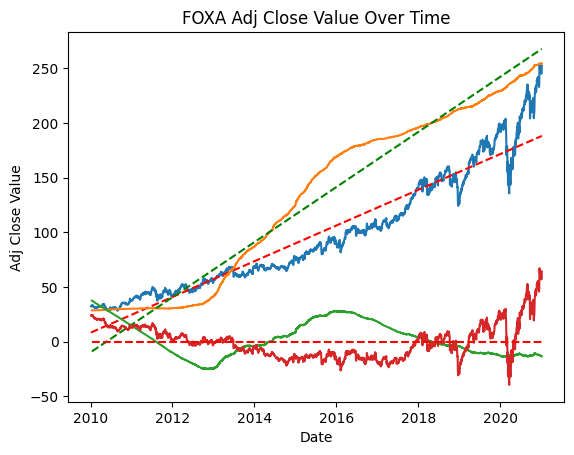

Correlation: 0.5952380952380953 | Transformed: 0.8333333333333335


In [25]:
symbol = list(top_trans_stock.keys())[0]

plt.plot(company_stock['Date'], company_stock[stock_type])
z = np.polyfit(mdates.date2num(company_stock['Date']), company_stock[stock_type], 1)
p = np.poly1d(z)
plt.plot(company_stock['Date'], p(mdates.date2num(company_stock['Date'])), "r--", label='Trend Line (Stock)')

plt.plot(company_trump['date'], company_trump['polarityScaled'])
z_polarity = np.polyfit(mdates.date2num(company_trump['date']), company_trump['polarityScaled'], 1)
p_polarity = np.poly1d(z_polarity)
plt.plot(company_trump['date'], p_polarity(mdates.date2num(company_trump['date'])), "g--", label='Trend Line (Polarity)')

# Plot the flattened trend
_, transformed_polarity, _ = flatten_trend(company_trump['date'], company_trump['polarityScaled'])
company_trump["transformedPolarityScaled"] = transformed_polarity
_, transformed_adj_close, _ = flatten_trend(company_stock['Date'], company_stock[stock_type])
company_stock["transformedAdjClose"] = transformed_adj_close

plt.plot(company_trump['date'], transformed_polarity)
plt.plot(company_stock['Date'], transformed_adj_close)
plt.hlines(y=0, xmin=stock_values["Date"].min(), xmax=stock_values["Date"].max(), color='r', linestyle='--')

plt.xlabel('Date')
plt.ylabel(stock_type + ' Value')
plt.title(symbol + ' ' + stock_type + ' Value Over Time')
plt.show()

std, trans = compute_correlation(symbol, stock_type, method)

print("Correlation: " + str(std) + " | Transformed: " + str(trans))